In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

#emcee
import emcee
import corner as corner
import time

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d

### TQDM
from tqdm import tqdm_notebook

In [2]:
def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOKASC

In [4]:
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')
dr16 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r12-l33.fits.gz')
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

<ipython-input-4-c45f30211bba>:4: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


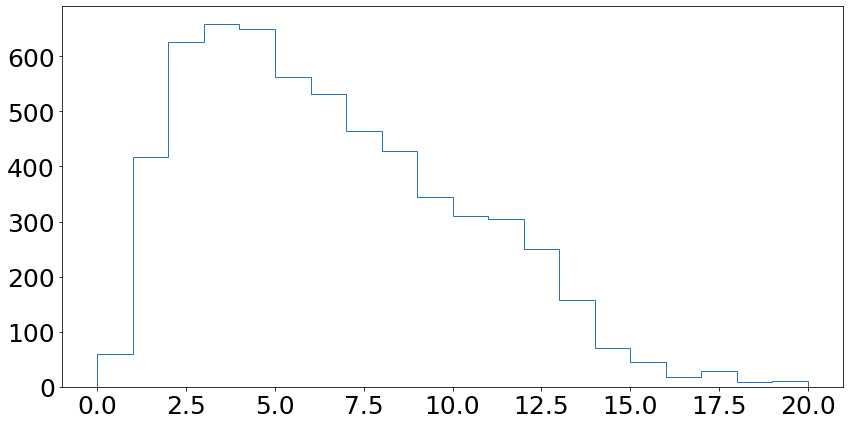

In [19]:
k674 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.4.fits.gz')

# xmatch APOKASC with DR17
_, k674idx, dr17idx = np.intersect1d(k674['2MASS_ID'],dr17['APOGEE_ID'],return_indices=True)

k674 = k674[k674idx]
kdr17 = dr17[dr17idx]


# Select RGB stars
ageevs = np.where((k674['A3P_AGEMOD_JT']>-10.)&(k674['APOKASC3_CONS_EVSTATES']==1.0))

k674 = k674[ageevs]
kdr17 = kdr17[ageevs]

plt.figure(figsize=[14,7])
plt.hist(k674['A3P_AGEMOD_JT'],histtype='step',range=(0,20),bins=20)
plt.show()

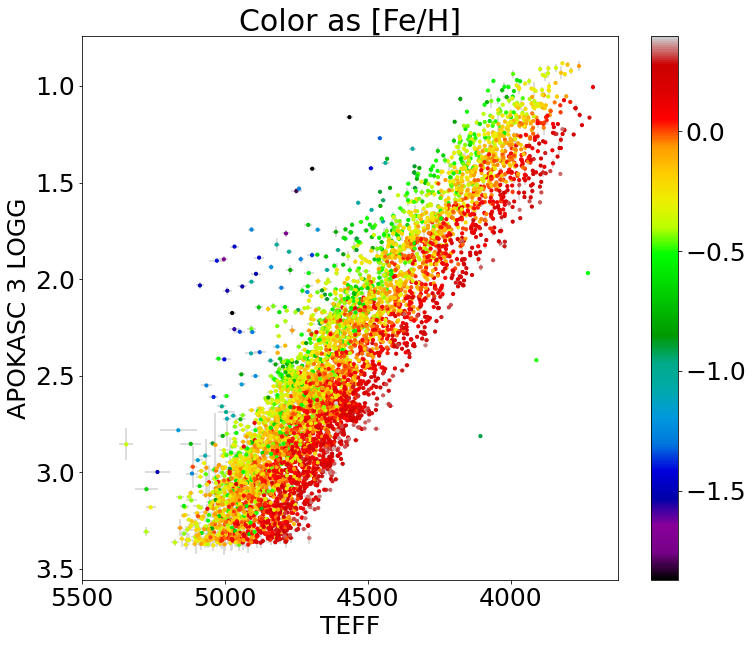

In [65]:
plt.figure(figsize=[12,10])
plt.scatter(kdr17['TEFF'],k674['APOKASC3P_LOGG'],c=kdr17['FE_H'],s=10,cmap='nipy_spectral')
plt.colorbar()
plt.errorbar(kdr17['TEFF'],k674['APOKASC3P_LOGG'],xerr=kdr17['TEFF_ERR'],yerr=k674['APOKASC3P_LOGG_ERR'],
             ls=' ',c='lightgrey',zorder=0)

plt.xlim(right=5500)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'TEFF')
plt.ylabel(r'APOKASC 3 LOGG');

# Gaia EDR3

In [37]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

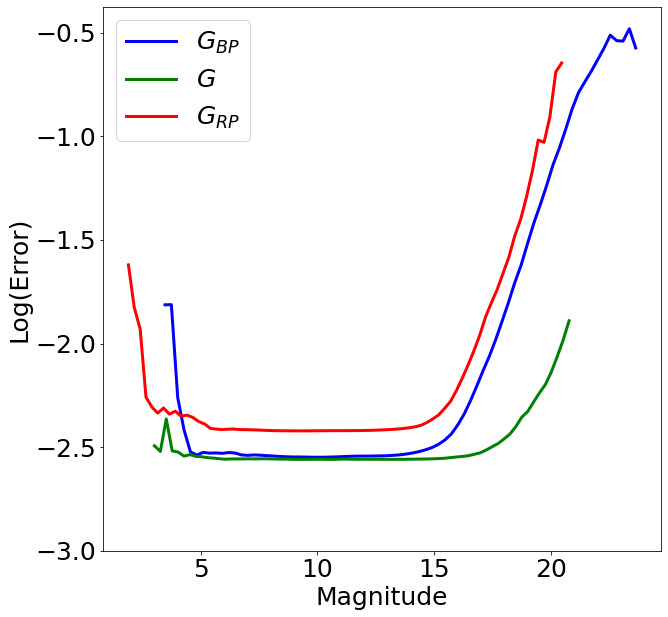

In [38]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = IUS(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(kdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

In [ ]:
def logg_cal(logg,mh):
    '''
    ASPCAP Log(g) calibration from J\"{o}nsson et al. 2020
    
    Inputs:
    ------
        logg: uncalibrated log(g) value (FPARAM[1])
        mh: unclaibrated [M/H] value (FPARAM[3])
    
    Output:
    ------
        cal_logg: calibrated Log(g) value
    '''
    
    X = (logg, mh)
    
    def one(X):
        '''
        (logg>=1.2795)&(mh>0.5)
        '''
        logg, mh = X
        return -0.441 + 0.7588*logg - 0.2667*logg**2 + 0.02819*logg**3 + 0.1346*0.5

    def two(X):
        '''
        (logg>=1.2795)&(mh<=0.5)
        '''
        logg, mh = X
        return -0.441 + 0.7588*logg - 0.2667*logg**2 + 0.02819*logg**3 + 0.1346*mh

    def three(X):
        '''
        (logg<1.2795)&(mh>0.5)
        '''
        logg, mh = X
        return -0.441 + 0.7588*(1.2745) - 0.2667*(1.2745)**2 + 0.02819*(1.2745)**3 + 0.1346*0.5
    
    def four(X):
        '''
        (logg<1.2795)&(mh<=0.5)
        '''
        logg, mh = X
        return -0.441 + 0.7588*(1.2745) - 0.2667*(1.2745)**2 + 0.02819*(1.2745)**3 + 0.1346*mh

    result = np.piecewise(
        X,
        [(logg>=1.2795)&(mh>0.5), (logg>=1.2795)&(mh<=0.5), (logg<1.2795)&(mh>0.5), (logg<1.2795)&(mh<=0.5)],
        [lambda y: logg - one(y), lambda y: logg - two(y), lambda y: logg - three(y), lambda y: logg - four(y)],
    )
    return result 

# Calculate the shift in FPARAM logg as a function of FPARAM logg

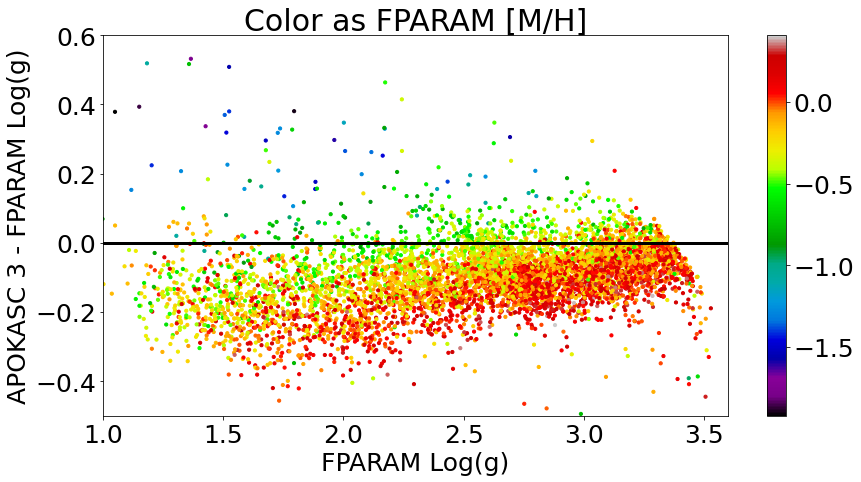

In [52]:
plt.figure(figsize=[14,7])
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)

plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.xticks(np.arange(0,4.0,0.5))

plt.xlim(1.0,3.6)
plt.ylim(-0.5,0.6)

plt.title(r'Color as FPARAM [M/H]')
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.show()

In [ ]:
plt.figure(figsize=[14,7])
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)

plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.xticks(np.arange(0,4.0,0.5))

plt.xlim(1.0,3.6)
plt.ylim(-0.5,0.6)

plt.title(r'Color as FPARAM [M/H]')
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.show()

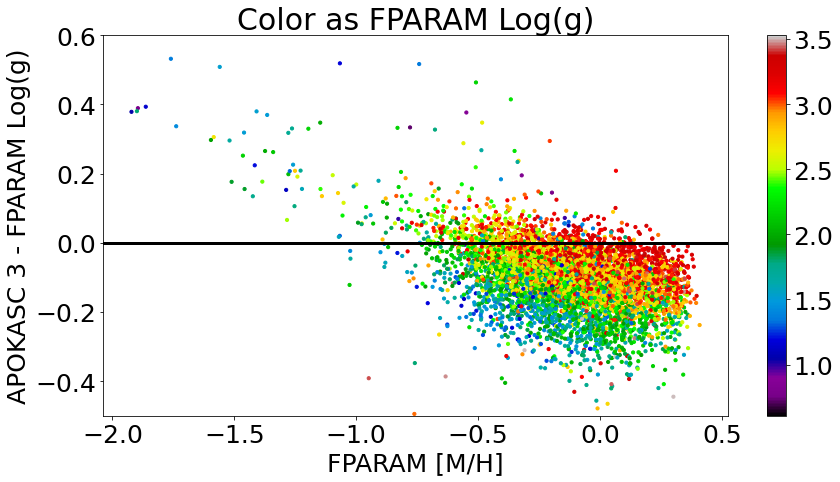

In [50]:
plt.figure(figsize=[14,7])
plt.scatter(kdr17['FPARAM'][:,3],k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
            c=kdr17['FPARAM'][:,1],cmap='nipy_spectral',s=10)

plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.5,0.6)

plt.title(r'Color as FPARAM Log(g)')
plt.xlabel(r'FPARAM [M/H]')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.show()